In [3]:
import Model
import tensorflow as tf
import os
import re
import hashlib
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

from extractMFCC import computeFeatures, computeFeatures1
from addNoise import addNoise
print(tf.__version__)

2.0.0-beta0


In [4]:
testWAVs = pd.read_csv('Dataset/testing_list.txt', sep=" ", header=None)[0].tolist()
valWAVs  = pd.read_csv('Dataset/validation_list.txt', sep=" ", header=None)[0].tolist()

for idx, item in enumerate(testWAVs):
    testWAVs[idx] = "Dataset/" + testWAVs[idx]

for idx, item in enumerate(valWAVs):
    valWAVs[idx] = "Dataset/" + valWAVs[idx]

In [5]:
DictCategs = {'nine' : 1, 'yes' : 2, 
                         'no' : 3, 'up' : 4, 'down' : 5, 'left' : 6, 'right' : 7, 'on' : 8, 'off' : 9, 'stop' : 10, 'go' : 11,
                         'zero' : 12, 'one' : 13, 'two' : 14, 'three' : 15, 'four' : 16, 'five' : 17, 'six' : 18, 
                         'seven' : 19,  'eight' : 20, 'backward':0, 'bed':0, 'bird':0, 'cat':0, 'dog':0,
                         'follow':0, 'forward':0, 'happy':0, 'house':0, 'learn':0, 'marvin':0, 'sheila':0, 'tree':0,
                         'visual':0, 'wow':0}
nCategs = 21

In [6]:
allWAVs  = []
for root, dirs, files in os.walk('Dataset/'):
    if root != "Dataset/_background_noise_":
        allWAVs += [root+'/'+ f for f in files if f.endswith('.wav')]
trainWAVs = list( set(allWAVs)-set(valWAVs)-set(testWAVs) )

In [8]:
print(len(trainWAVs))
print(len(valWAVs))
print(len(testWAVs))

84843
9981
11005


In [9]:
def _getFileCategory(file, catDict):
    """
    Receives a file with name Dataset/<cat>/<filename> and returns an integer that is catDict[cat]
    """
    categ = os.path.basename(os.path.dirname(file))
    return catDict.get(categ,0)

In [10]:
#get categories
testWAVlabels = [_getFileCategory(f, DictCategs) for f in testWAVs]
valWAVlabels = [_getFileCategory(f, DictCategs) for f in valWAVs]
trainWAVlabels = [_getFileCategory(f, DictCategs) for f in trainWAVs]

In [11]:
print(len(trainWAVlabels))
print(len(valWAVlabels))
print(len(testWAVlabels))

84843
9981
11005


In [12]:
train = np.zeros((len(trainWAVlabels), 99, 39))
for i in range(len(trainWAVs)):
    #print(i)
    train[i, :, :] = computeFeatures(trainWAVs[i])
#prova = computeFeatures(trainWAVs[0])
#print(prova.shape)

/home/jupyter/HDA_Project/extractMFCC.py:25: RuntimeWarning: invalid value encountered in log10
  log_E_s = np.log10(E_s)
/home/jupyter/HDA_Project/extractMFCC.py:39: RuntimeWarning: divide by zero encountered in log10
  log_E_deltas = np.log10(E_deltas)
/home/jupyter/HDA_Project/extractMFCC.py:44: RuntimeWarning: divide by zero encountered in log10
  log_E_deltas_2 = np.log10(E_deltas_2)


KeyboardInterrupt: 

In [13]:
#np.save('train.npy', train)
train = np.load('train.npy')

(84843, 99, 39, 1)


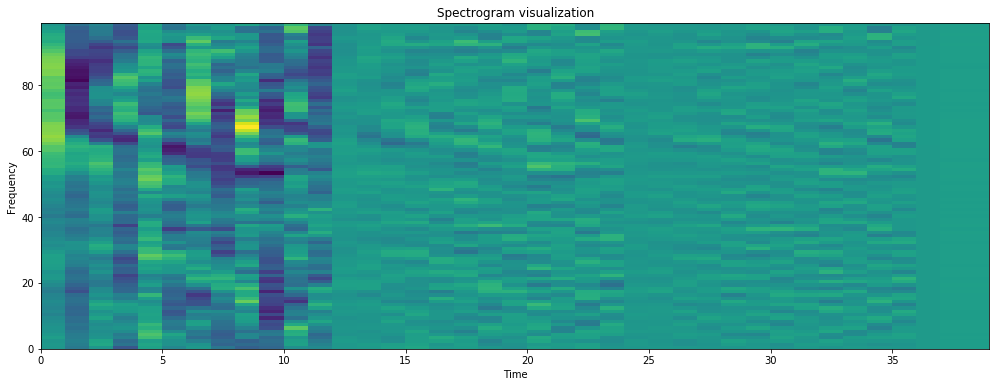

In [14]:
train = train.reshape(train.shape[0], 99, 39, 1)
print(train.shape)

plt.figure(figsize=(17,6))
plt.pcolormesh(train[1111,:,:,0])

plt.title('Spectrogram visualization')
plt.ylabel('Frequency')
plt.xlabel('Time')

plt.show()

In [15]:
model = Model.AttentionModel(21, 99, 39, use_GRU = True)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 99, 39, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 99, 39, 10)   60          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 99, 39, 10)   40          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 99, 39, 1)    51          batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

results = model.fit(x = train, y = trainWAVlabels, batch_size = 32, epochs = 1, use_multiprocessing = True, workers = 4, verbose = 1, shuffle = True)

Train on 84843 samples
55136/84843 [==================>...........] - ETA: 16:35 - loss: 2.7728 - accuracy: 0.2719